In [1]:
from PIL import Image
import os
import numpy as np

def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    width, height = img.size
    if width > height:
        new_width = height
        left = (width - new_width) // 2
        right = left + new_width
        img = img.crop((left, 0, right, height))
    elif height > width:
        new_height = width
        top = (height - new_height) // 2
        bottom = top + new_height
        img = img.crop((0, top, width, bottom))
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

image_dir = 'ISIC-images/'
target_size = (128, 128)
image_arrays = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img_array = preprocess_image(img_path, target_size=target_size)
    image_arrays.append(img_array)

X = np.array(image_arrays)

In [2]:
import pandas as pd

metadata = pd.read_csv('metadata.csv')
y = metadata['diagnosis']

In [3]:
from sklearn.model_selection import train_test_split

random_state = 101
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=random_state, stratify=y_train_val)

In [4]:
classInstances = y_train.value_counts()

In [5]:
classInstances

diagnosis
nevus                         6266
pigmented benign keratosis    1084
melanoma                      1057
basal cell carcinoma           504
squamous cell carcinoma        185
vascular lesion                146
dermatofibroma                 130
actinic keratosis              121
Name: count, dtype: int64

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

undersample_strategy = {label: 1000 for label in set(y_train) if y_train.value_counts()[label] > 1000}
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

oversample_strategy = {label: 1000 for label in set(y_train_under) if y_train_under.value_counts()[label] < 1000}
oversampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_under, y_train_under)

X_train_balanced = X_train_balanced.reshape(-1, 128, 128, 3)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [7]:
y_train_balanced.value_counts()

diagnosis
nevus                         1000
melanoma                      1000
pigmented benign keratosis    1000
actinic keratosis             1000
vascular lesion               1000
squamous cell carcinoma       1000
basal cell carcinoma          1000
dermatofibroma                1000
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_train_one_hot = to_categorical(y_train_encoded)
y_val_encoded = label_encoder.fit_transform(y_val)
y_val_one_hot = to_categorical(y_val_encoded)
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train_balanced)

history = model.fit(
    datagen.flow(X_train_balanced, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[early_stopping]
)

c:\Users\arsen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 242ms/step - accuracy: 0.1637 - loss: 2.0338 - val_accuracy: 0.0341 - val_loss: 1.7917
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.2125 - loss: 1.8552 - val_accuracy: 0.1062 - val_loss: 1.7425
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.2691 - loss: 1.7729 - val_accuracy: 0.3592 - val_loss: 1.8286
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - accuracy: 0.3097 - loss: 1.6921 - val_accuracy: 0.5289 - val_loss: 1.3335
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 242ms/step - accuracy: 0.3247 - loss: 1.6324 - val_accuracy: 0.3915 - val_loss: 1.4861
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 251ms/step - accuracy: 0.3559 - loss: 1.5791 - val_accuracy: 0.2929 - val_loss: 1.4377
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 251ms/step - accuracy: 0.3615 - loss: 1.5683 - val_accuracy: 0.5100 - val_loss: 1.2356
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.3904 - loss: 1

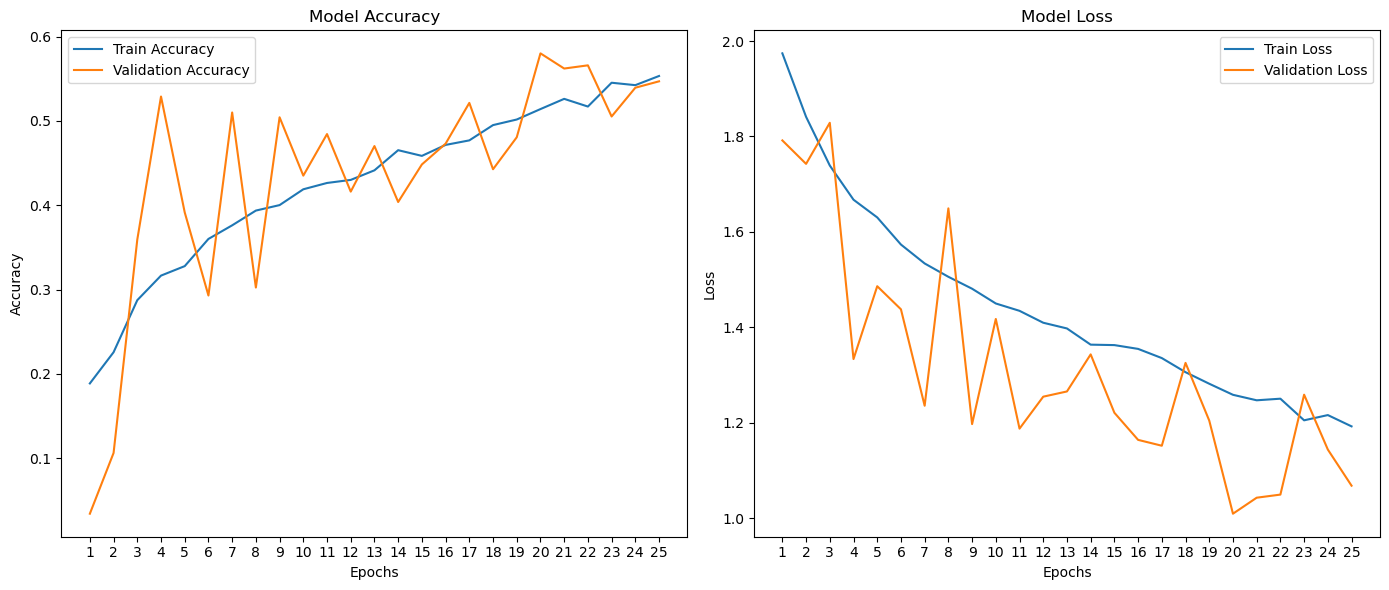

In [10]:
import matplotlib.pyplot as plt

total_epochs = len(history.history['accuracy'])
xticks_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(xticks_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(xticks_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(xticks_range)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xticks_range, history.history['loss'], label='Train Loss')
plt.plot(xticks_range, history.history['val_loss'], label='Validation Loss')
plt.xticks(xticks_range)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


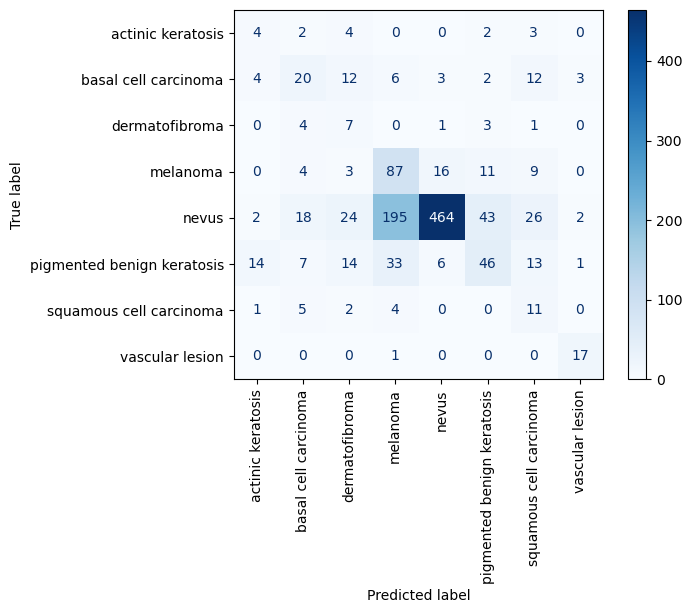

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [12]:
X_under, y_under = undersampler.fit_resample(X.reshape(X.shape[0], -1), y)
X_balanced, y_balanced = oversampler.fit_resample(X_under.reshape(X_under.shape[0], -1), y_under)
X_balanced = X_balanced.reshape(-1, 128, 128, 3)

In [13]:
y_encoded = label_encoder.fit_transform(y_balanced)
y_one_hot = to_categorical(y_encoded)

In [14]:
model_final = Sequential()

model_final.add(Input(shape=(128, 128, 3)))
model_final.add(Conv2D(32, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(64, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(128, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(256, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))

model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(32, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen.fit(X_balanced)

val_loss = history.history['val_loss']

optimal_total_epochs = val_loss.index(min(val_loss)) + 1

model_final.fit(datagen.flow(X_balanced, y_one_hot, batch_size=32), epochs=optimal_total_epochs)

c:\Users\arsen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.1587 - loss: 2.0540
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.2123 - loss: 1.8906
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.2892 - loss: 1.7715
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.3178 - loss: 1.6880
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.3335 - loss: 1.6353
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.3496 - loss: 1.6040
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.3592 - loss: 1.5777
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.3817 - loss: 1.5389
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 152ms/step - accuracy: 0.3824 - loss: 1.5277
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.4082 - loss: 1.4899
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.4209 - loss: 1.4643
Epoch 12/20
250/250

In [15]:
import joblib

joblib.dump(model_final, 'model.pkl')

['model.pkl']

In [16]:
classes = y_balanced.unique()
classes = pd.DataFrame(classes, columns=['class'])
classes.to_csv('classes.csv')